# **Bike-Share User Behavior & Membership Conversion Analysis**
## -Kaviraj Waghmare

## **Objective**
Analyze ride patterns, seasonality, and user behavior to
identify key differences between casual riders and members,
and generate data-driven insights to convert casual riders
into long-term members.

## **Key Focus Areas**
- Commuter vs Leisure behavior  
- Time-of-day and seasonal trends  
- Demographic and station-level insights 

## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set professional aesthetics
sns.set_theme(style="whitegrid")
palette = {"Subscriber": "#2ecc71", "Customer": "#3498db", "Member": "#2ecc71", "Casual": "#3498db"} 
# Note: Adjust keys based on your specific 'usertype' labels (e.g., 'Subscriber' or 'Member')


## Data Loading and Cleaning

In [12]:
# Load quarterly data
q1 = pd.read_csv("Divvy_Trips_2019_Q1.csv")
q2 = pd.read_csv("Divvy_Trips_2019_Q2.csv")
q3 = pd.read_csv("Divvy_Trips_2019_Q3.csv")
q4 = pd.read_csv("Divvya_Trips_2019_Q4.csv")


In [13]:
full_year_data = pd.concat([q1, q2, q3, q4], ignore_index=True)


In [88]:
# Clean & prepare data (core analytics step)
# Standardize user type naming

full_year_data['usertype'] = full_year_data['usertype'].replace({
    'Subscriber': 'member',
    'Customer': 'casual'
})


In [93]:
# Convert datetime columns
full_year_data['start_time'] = pd.to_datetime(full_year_data['start_time'], errors='coerce')
full_year_data['end_time'] = pd.to_datetime(full_year_data['end_time'], errors='coerce')

# Ride length in minutes
full_year_data['ride_length'] = pd.to_numeric(
    full_year_data['tripduration'],
    errors='coerce'
)

# Extract date components
full_year_data['day_of_week'] = full_year_data['start_time'].dt.dayofweek + 1
full_year_data['month'] = full_year_data['start_time'].dt.month
full_year_data['year'] = full_year_data['start_time'].dt.year

# Age calculation
full_year_data['birthyear'] = pd.to_numeric(full_year_data['birthyear'], errors='coerce')
full_year_data['age'] = full_year_data['year'] - full_year_data['birthyear']

# Apply filters (data quality checks)
cleaned_data = full_year_data[
    (full_year_data['end_time'] > full_year_data['start_time']) &   # Valid trip duration
    (full_year_data['usertype'].notna()) &                          # Known user type
    (full_year_data['ride_length'] > 0) &                           # Positive ride length
    (full_year_data['from_station_name'] != "HQ QR")               # Remove test station
].copy()

print("Records after cleaning:", cleaned_data.shape[0])


Records after cleaning: 1793966


## DESCRIPTIVE ANALYSIS

In [162]:
# ============================================
# SECTION 1: MEMBER vs CASUAL BEHAVIOR
# ============================================

# 1. Who rides more? (Ride count)
ride_counts = analysis_data['usertype'].value_counts()

print("Ride Count by User Type:")
print(ride_counts)
print("""
Insight: Members dominate usage (~1.6M rides) compared to casual riders (~186K),
indicating the system is primarily driven by regular, repeat user.
""")


# 2. Average & Median Ride Length
analysis_data['ride_length_min'] = analysis_data['ride_length'] / 60

ride_length_stats = (
    analysis_data
    .groupby('usertype', observed=True)['ride_length_min']
    .agg(['mean', 'median'])
    .round(2)
)

print("Average & Median Ride Length (minutes):")
print(ride_length_stats)
print("""
Insight: Casual riders exhibit longer average and median ride durations (~10–11 minutes), indicating leisure-oriented usage.
Members complete shorter trips (~8 minutes), consistent with efficient, routine commuting behavior.
""")


# 3. Ride Behavior by Day of Week
analysis_data['day_of_week'] = analysis_data['start_time'].dt.day_name()

days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

analysis_data['day_of_week'] = pd.Categorical(
    analysis_data['day_of_week'],
    categories=days_order,
    ordered=True
)

avg_ride_by_day = (
    analysis_data
    .groupby(['usertype', 'day_of_week'], observed=True)['ride_length']
    .mean()
    .round(2)
)

print("Average Ride Length by Day of Week:")
print(avg_ride_by_day)
print("""
Insight: Casual ride duration increases on weekends, while member ride duration remains 
consistent throughout the weeks.
""")


# 4. Number of Rides by Day of Week
rides_by_day = (
    analysis_data
    .groupby(['usertype', 'day_of_week'], observed=True)['trip_id']
    .count()
)

print("Number of Rides by Day of Week:")
print(rides_by_day)
print("\nInsight: Members show consistent weekday usage; casual riders spike on weekends.\n")


# 5. Monthly Trend (Seasonality)
monthly_trend = (
    analysis_data
    .groupby(['usertype', 'month'], observed=True)['trip_id']
    .count()
)

print("Monthly Ride Trend:")
print(monthly_trend)
print("\nInsight: Both groups peak in summer, but seasonality impacts casual riders much more than members.\n")


# ============================================
# SECTION 2: STATION POPULARITY ANALYSIS
# ============================================

# Most Popular Start Station
most_popular_start = (
    analysis_data
    .groupby('from_station_name', observed=True)
    .size()
    .reset_index(name='trips')
    .sort_values('trips', ascending=False)
    .head(1)
)

# Most Popular End Station
most_popular_end = (
    analysis_data
    .groupby('to_station_name', observed=True)
    .size()
    .reset_index(name='trips')
    .sort_values('trips', ascending=False)
    .head(1)
)

print("Most Popular Start Station:")
print(most_popular_start)

print("\nMost Popular End Station:")
print(most_popular_end)

print("""
Insight:A small number of stations account for a large share of trips, highlighting key mobility hubs.
Business Impact:Critical for bike rebalancing and capacity planning.
""")


# ============================================
# SECTION 3: RIDER DEMOGRAPHICS ANALYSIS
# ============================================

# Average Age of Riders
avg_age = analysis_data[
    analysis_data['age'].between(10, 90)
]['age'].mean()

print("\nAverage Rider Age:", round(avg_age, 1))
print("\nInsight:  Most riders are aged 10–50.\n")


# Gender Distribution
gender_distribution = (
    analysis_data
    .dropna(subset=['gender'])
    .groupby('gender', observed=True)
    .size()
    .reset_index(name='count')
)

print("\nGender Distribution:")
print(gender_distribution)
print("""
Insight: Male riders significantly outnumber female riders, indicating a potential
growth opportunity through inclusivity initiatives.
""")


# Age Group Analysis
def assign_age_group(age):
    if 10 <= age <= 30:
        return '10–30'
    elif 31 <= age <= 50:
        return '31–50'
    elif 51 <= age <= 90:
        return '51–90'
    else:
        return np.nan

analysis_data['age_group'] = analysis_data['age'].apply(assign_age_group)

age_group_summary = (
    analysis_data
    .dropna(subset=['age_group'])
    .groupby('age_group', observed=True)
    .size()
    .reset_index(name='ride_count')
)

print("\nAge Group Distribution:")
print(age_group_summary)
print("\nInsight: The 10–30 and 31–50 age groups generate the majority of rides, with usage declining after age 50.\n")


# ============================================
# FINAL BUSINESS SUMMARY
# ============================================

print("""
1. USER BEHAVIOR INSIGHTS:
   • The Commuter Engine: Members (89% of rides) use the system for daily utility, 
     peaking on Tuesdays/Wednesdays with shorter, efficient trips.
   • The Leisure Spike: Casual riders peak on weekends and keep bikes 28% longer 
     than members, suggesting recreational or tourist use.
   • Seasonal Volatility: Casual ridership is weather-dependent, exploding by 
     4,000% in Summer vs. Winter, while Members remain more stable.

2. LOGISTICS & DEMOGRAPHICS:
   • Transit Hubs: Canal St & Clinton St stations are the system's "heart," 
     serving as the primary last-mile connection for train commuters.
   • Target Audience: 76% of users are Male, and 85% are aged 10–50. 
     There is a significant growth opportunity within the female demographic.
     """)

Ride Count by User Type:
usertype
member    1608244
casual     185722
Name: count, dtype: int64

Insight: Members dominate usage (~1.6M rides) compared to casual riders (~186K),
indicating the system is primarily driven by regular, repeat user.

Average & Median Ride Length (minutes):
           mean  median
usertype               
casual    10.66   10.92
member     8.31    7.83

Insight: Casual riders exhibit longer average and median ride durations (~10–11 minutes), indicating leisure-oriented usage.
Members complete shorter trips (~8 minutes), consistent with efficient, routine commuting behavior.

Average Ride Length by Day of Week:
usertype  day_of_week
casual    Monday         632.18
          Tuesday        626.54
          Wednesday      630.22
          Thursday       632.16
          Friday         632.16
          Saturday       657.13
          Sunday         652.31
member    Monday         498.83
          Tuesday        499.09
          Wednesday      499.91
          Thu

## Data Visualization & Trend Exploration

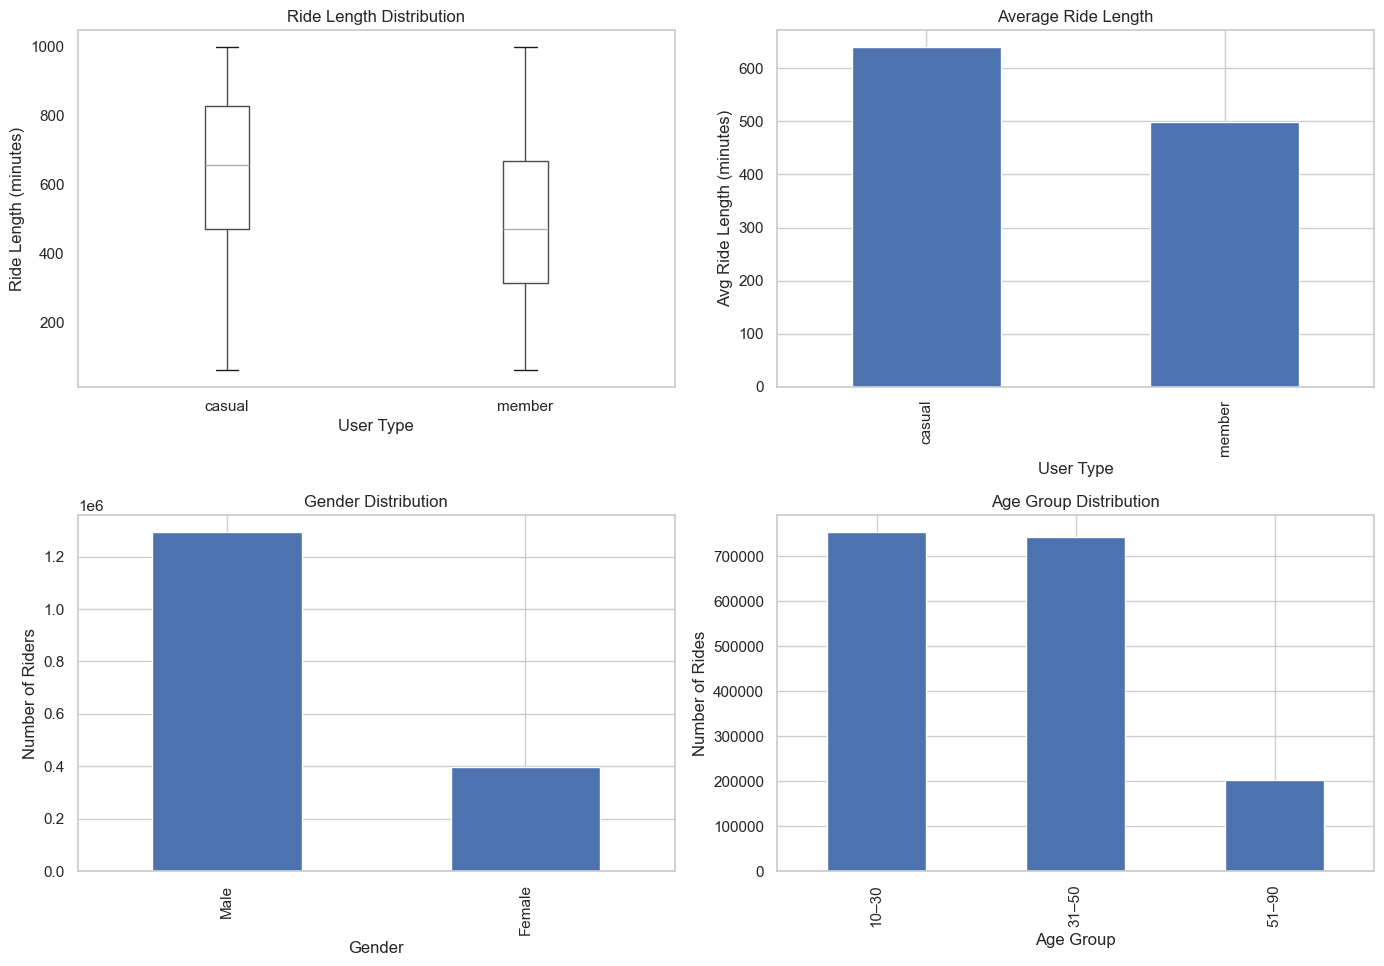

In [154]:
import matplotlib.pyplot as plt

fig1, axes = plt.subplots(2, 2, figsize=(14, 10))
fig1.suptitle("User Behavior & Demographics Overview", fontsize=14)

# 1. Ride Length Distribution by User Type
cleaned_data.boxplot(
    column='ride_length',
    by='usertype',
    ax=axes[0, 0],
    grid=False
)
axes[0, 0].set_title("Ride Length Distribution")
axes[0, 0].set_xlabel("User Type")
axes[0, 0].set_ylabel("Ride Length (minutes)")

# 2. Average Ride Length by User Type
avg_ride_by_user = cleaned_data.groupby('usertype')['ride_length'].mean()
avg_ride_by_user.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title("Average Ride Length")
axes[0, 1].set_xlabel("User Type")
axes[0, 1].set_ylabel("Avg Ride Length (minutes)")

# 3. Gender Distribution
cleaned_data['gender'].value_counts().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title("Gender Distribution")
axes[1, 0].set_xlabel("Gender")
axes[1, 0].set_ylabel("Number of Riders")

# 4. Age Group Distribution
cleaned_data['age_group'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title("Age Group Distribution")
axes[1, 1].set_xlabel("Age Group")
axes[1, 1].set_ylabel("Number of Rides")

plt.suptitle("")
plt.tight_layout()
plt.show()

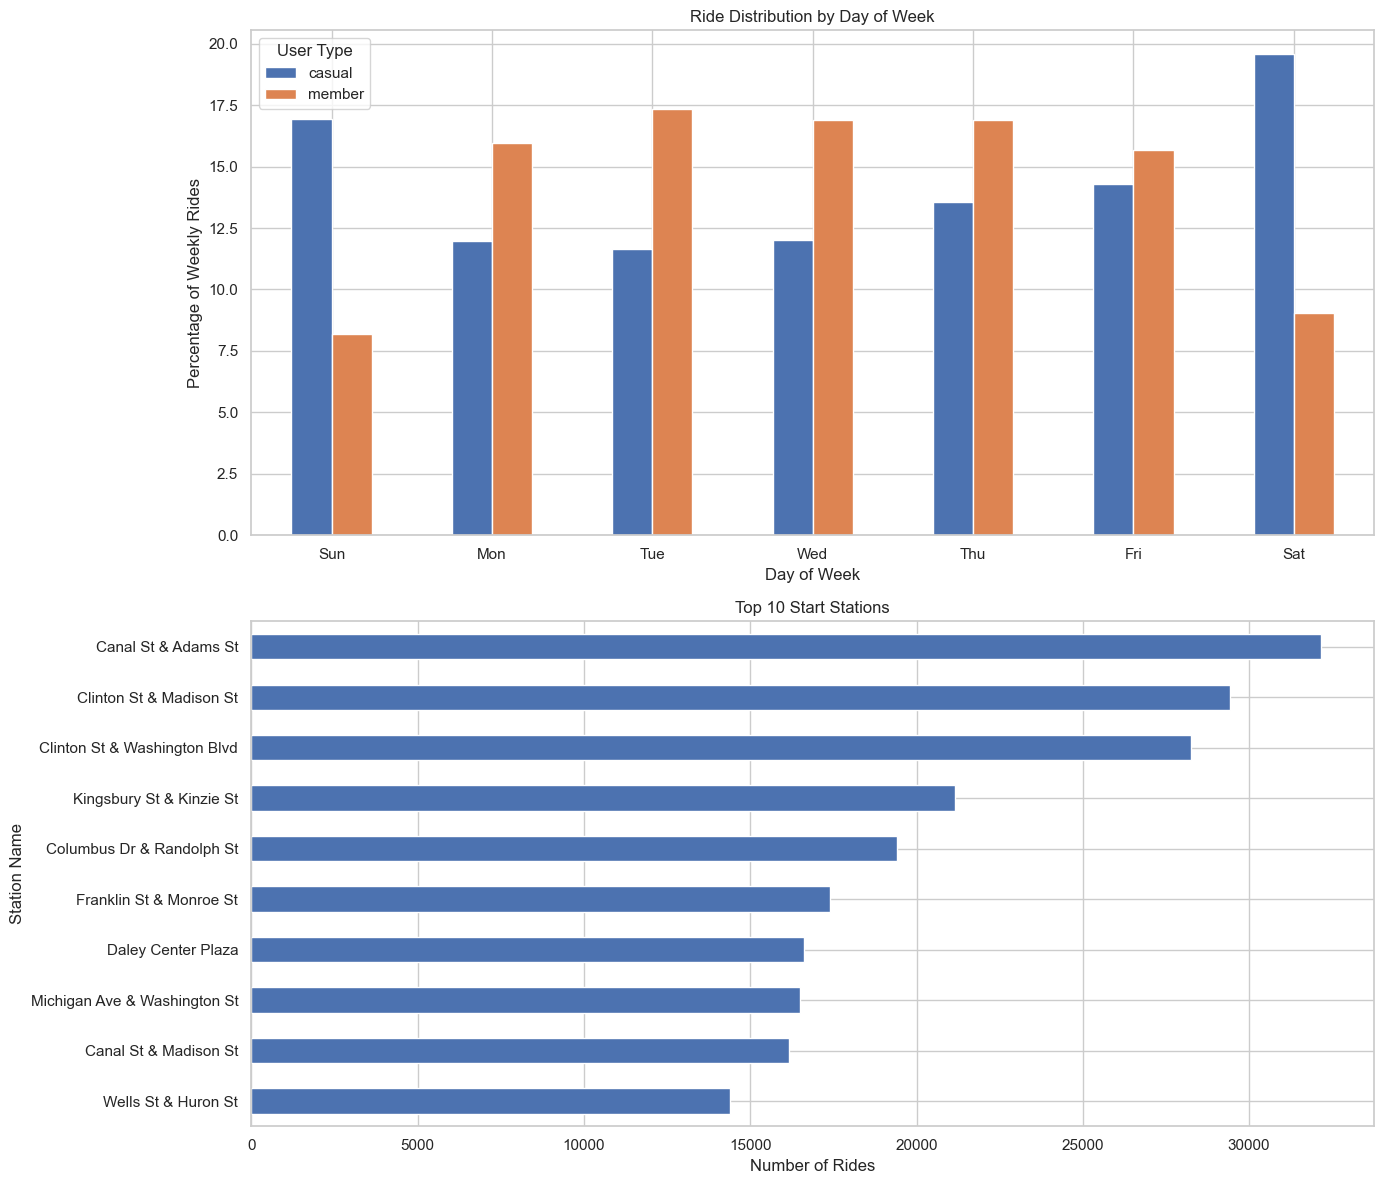

In [155]:
fig2, axes = plt.subplots(2, 1, figsize=(14, 12))

# 5. Ride Volume by Day of Week
day_user_counts = (
    cleaned_data
    .groupby(['usertype', 'day_of_week'])
    .size()
    .reset_index(name='rides')
)

day_user_counts['percent'] = (
    day_user_counts
    .groupby('usertype')['rides']
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(drop=True)
)

pivot_df = day_user_counts.pivot_table(
    index='day_of_week',
    columns='usertype',
    values='percent',
    aggfunc='mean'
)

day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

pivot_df = pivot_df.reindex(day_order)

pivot_df.plot(kind='bar', ax=axes[0])
axes[0].set_title("Ride Distribution by Day of Week")
axes[0].set_xlabel("Day of Week")
axes[0].set_ylabel("Percentage of Weekly Rides")
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], rotation=0)
axes[0].legend(title="User Type")

# 6. Top 10 Start Stations
cleaned_data['from_station_name'] \
    .value_counts() \
    .head(10) \
    .sort_values() \
    .plot(kind='barh', ax=axes[1])

axes[1].set_title("Top 10 Start Stations")
axes[1].set_xlabel("Number of Rides")
axes[1].set_ylabel("Station Name")

plt.tight_layout()
plt.show()

## Advanced Insights into Rider Behavior & System Usage

In [39]:
#Time-Series & Seasonality Analysis
monthly_trips = (
    cleaned_data
    .groupby(['month', 'usertype'])
    .size()
    .reset_index(name='trips')
)
monthly_trips

,month,usertype,trips
0,1.0,Customer,4602
1,1.0,Subscriber,98670
2,2.0,Customer,2638
3,2.0,Subscriber,93548
4,3.0,Customer,15923
5,3.0,Subscriber,149688
6,7.0,Customer,175632
7,7.0,Subscriber,381683
8,8.0,Customer,186889
9,8.0,Subscriber,403295


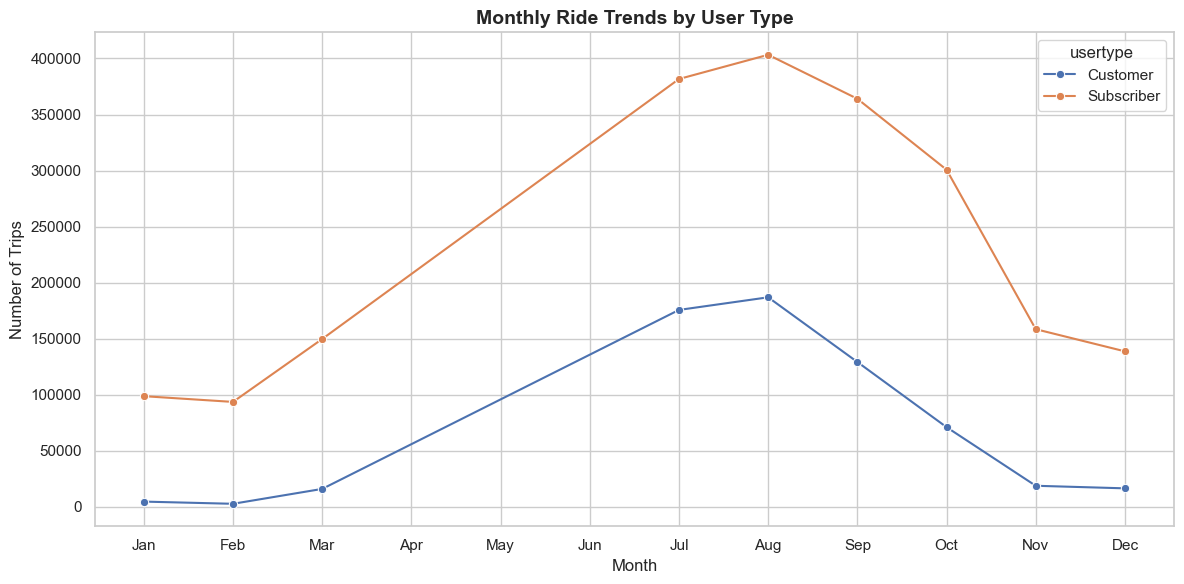

In [84]:
#Monthly Trend by User Type (Line Chart)
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=monthly_trips,
    x='month',
    y='trips',
    hue='usertype',
    marker='o'
)

plt.title('Monthly Ride Trends by User Type', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.xticks(
    ticks=range(1, 13),
    labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.tight_layout()
plt.show()

In [42]:
#Temporal Analysis: Identifying Peak Hours
# Extract the hour from start_time
cleaned_data['hour'] = cleaned_data['start_time'].dt.hour

# Group by hour and user type
hourly_usage = cleaned_data.groupby(['hour', 'usertype']).size().unstack()

# Analysis: Calculate the % of rides that happen in rush hours (7-9 AM, 4-6 PM)
rush_hours = [7, 8, 9, 16, 17, 18]
rush_data = hourly_usage.loc[rush_hours].sum()
print("Rush Hour Rides by User Type:\n", rush_data)

# Visualizing the Peak (Suggested for Matplotlib/Seaborn)
# hourly_usage.plot(kind='line', title='Hourly Ride Frequency')

Rush Hour Rides by User Type:
 usertype
Customer       209736
Subscriber    1119013
dtype: int64


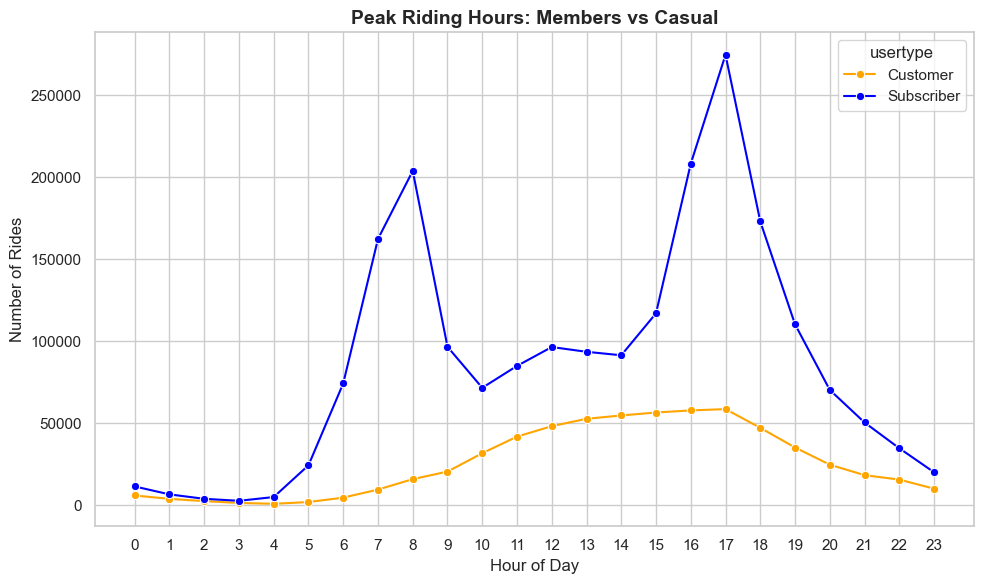

In [80]:
#Hourly Usage: Members vs Casual (Temporal Analysis)

# Define color palette
palette = {'Subscriber': 'blue', 'Customer': 'orange'}

# Prepare hourly data
hourly_usage = (
    cleaned_data
    .groupby(['hour', 'usertype'])
    .size()
    .reset_index(name='count')
)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=hourly_usage,
    x='hour',
    y='count',
    hue='usertype',
    palette=palette,
    marker='o'
)

plt.title('Peak Riding Hours: Members vs Casual', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

Top 10 Most Popular Routes:


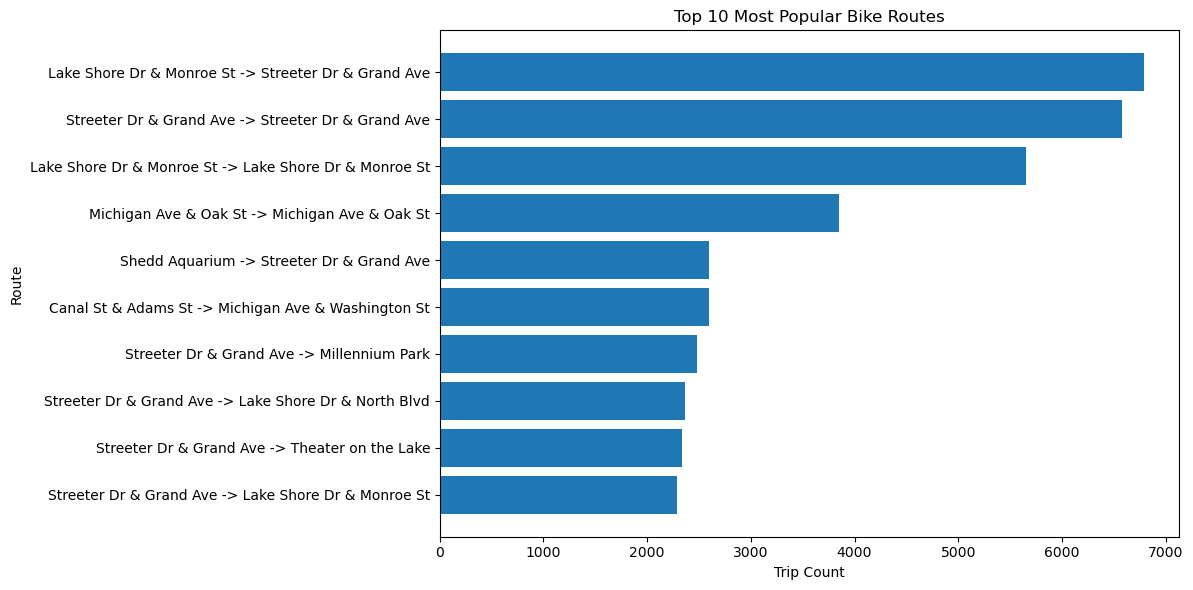

Percentage of Round Trips: 3.80%


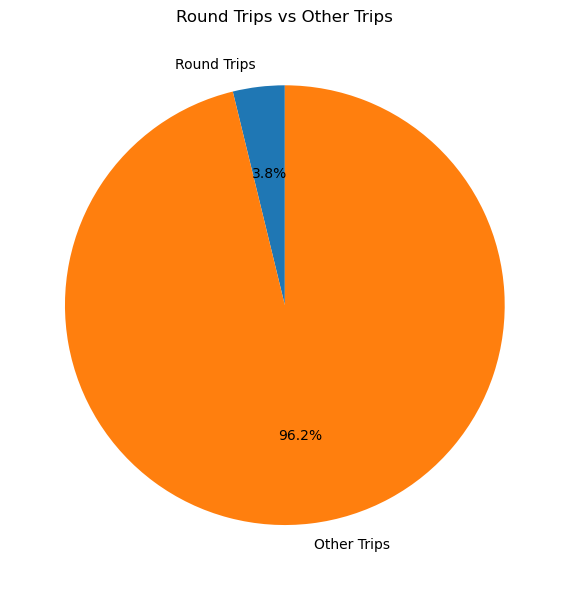

In [59]:
#Route Analysis: Most Frequent "Start-to-End" Paths
#Create a Route column
cleaned_data['route'] = cleaned_data['from_station_name'] + " -> " + cleaned_data['to_station_name']

# Find top 10 most common routes
top_routes = cleaned_data['route'].value_counts().head(10).reset_index()
top_routes.columns = ['Route', 'Trip Count']

print("Top 10 Most Popular Routes:")
# Plot Top 10 Routes
plt.figure(figsize=(12, 6))
plt.barh(top_routes['Route'], top_routes['Trip Count'])
plt.xlabel('Trip Count')
plt.ylabel('Route')
plt.title('Top 10 Most Popular Bike Routes')
plt.gca().invert_yaxis()  # Highest value on top
plt.tight_layout()
plt.show()

# Bonus: Find "Round Trips" (Started and ended at same station)
round_trips = cleaned_data[cleaned_data['from_station_name'] == cleaned_data['to_station_name']]
print(f"Percentage of Round Trips: {len(round_trips)/len(cleaned_data)*100:.2f}%")
labels = ['Round Trips', 'Other Trips']
values = [len(round_trips), len(cleaned_data) - len(round_trips)]

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Round Trips vs Other Trips')
plt.tight_layout()
plt.show()

## Final Insights Summary
**Members drive 89% of total rides with a "Double Peak" signature at 8 AM and 5 PM**; casual riders favor weekends and midday trips, keeping bikes 28% longer.

**Casual ridership explodes by 4,000% in summer compared to winter**; members provide a critical "revenue floor" with stable usage during cold months.

**Low round-trip rates (1.5%–3.8%) and hub-to-hub dominance (Canal St & Clinton St)** prove the system is a functional transit tool for connecting commuters from trains to offices.

**The user base is heavily Male (76%) and aged 10–50 (85%)**; this highlights a massive untapped growth opportunity within the female demographic and older age segments.

## Strategic Recommendations
**1.Summer-Only Membership Conversion :**
Casual rides surge in summer and riders stay longer on bikes. Offer short-term summer memberships and trigger offers after frequent weekend or long rides. This converts seasonal demand into steady revenue before winter.

**2️.Transit-Hub & Commute-Hour Targeting :**
Most trips are last-mile rides around Canal and Clinton stations during commute peaks. Provide hub-specific discounts and show upgrade prompts at 8 AM and 5 PM. This turns regular casual riders into daily commuter members.

**3.Time-Based Pricing to Build Habits :** 
Casual riders peak in the afternoon, while members ride during commute hours. Offer member-only off-peak credits and show savings after repeat rides. This nudges casual users toward routine use.